# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [51]:
import pickle as pkl
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

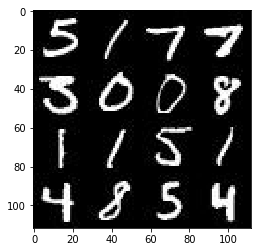

In [3]:
show_n_images = 24

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

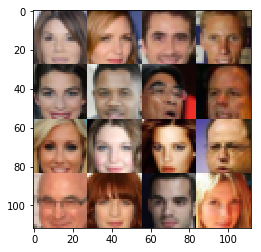

In [4]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_input = tf.placeholder(dtype=tf.float32,
                                shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(dtype=tf.float32,
                             shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(None), name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [70]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    # input is 28x28x1 for mnist
    # input is 28x28x3 for faces
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu_1 = tf.maximum(alpha * conv_1, conv_1)

        conv_2 = tf.layers.conv2d(lrelu_1, 128, 5, 2, 'SAME')
        batch_norm_2 = tf.layers.batch_normalization(conv_2, training=True)
        lrelu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        conv_3 = tf.layers.conv2d(lrelu_2, 256, 5, 1, 'SAME')
        batch_norm_3 = tf.layers.batch_normalization(conv_3, training=True)
        lrelu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
       
        flatten = tf.reshape(lrelu_3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [68]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        x_1 = tf.layers.dense(z, 2*2*512)
        
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        deconv_3 = tf.layers.conv2d_transpose(lrelu_2, 256, 5, 2, padding='VALID')
        batch_norm_3 = tf.layers.batch_normalization(deconv_3, training=is_train)
        lrelu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        deconv_4 = tf.layers.conv2d_transpose(lrelu_3, 128, 5, 2, padding='SAME')
        batch_norm_4 = tf.layers.batch_normalization(deconv_4, training=is_train)
        lrelu_4 = tf.maximum(alpha * batch_norm_4, batch_norm_4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu_4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """    
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [72]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param lr: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    print_every = 50
    show_every = 200

    out_channel_dim = len(data_image_mode)
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    real_input, z_input, lr_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                batch_images = batch_images * 2
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_tensor: lr})
                _ = sess.run(g_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_tensor: lr})
                
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess,
                                          n_images=16,
                                          input_z=z_input,
                                          out_channel_dim=out_channel_dim,
                                          image_mode=data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
        
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.7078


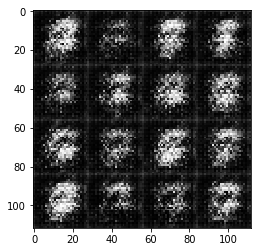

Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.7020
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.7691


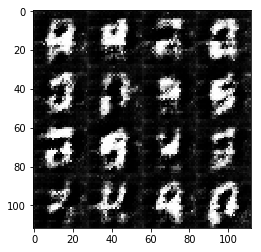

Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.7793


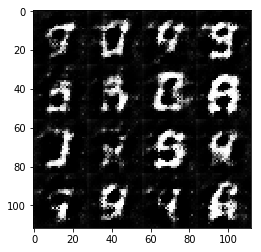

Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.7723


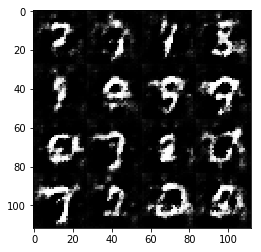

Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.7019


Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.7068


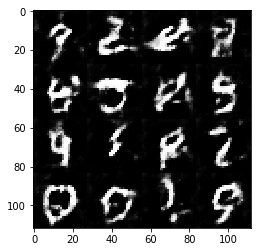

Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.7779


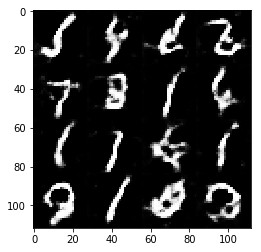

Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.7645


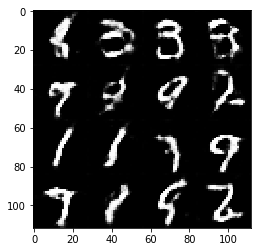

Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 0.7391


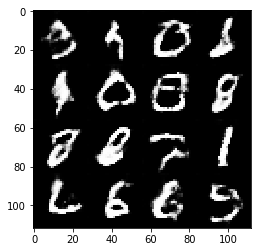

Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.7264


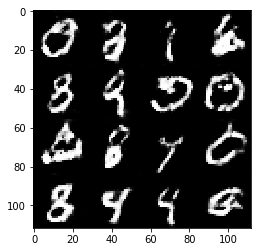

Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.0636


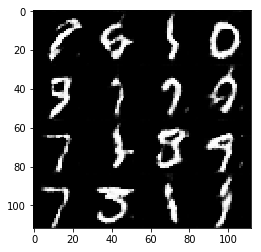

Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 0.9192
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.0213


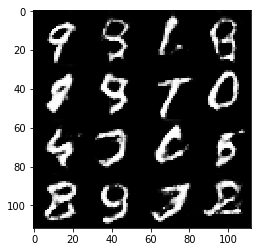

Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.0199
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.1299


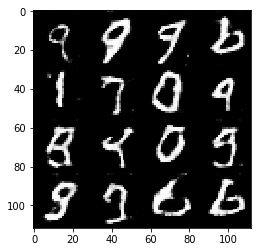

Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 0.8427


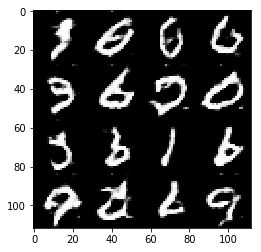

Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.2050
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.5564


Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.2487
Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 0.6434... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 1.3464


Epoch 1/2... Discriminator Loss: 0.4189... Generator Loss: 1.5414
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 0.5587... Generator Loss: 1.1408
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 1.1863


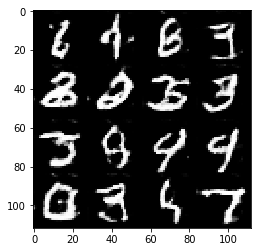

Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 1.9599
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.0693
Epoch 1/2... Discriminator Loss: 0.5966... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.5615


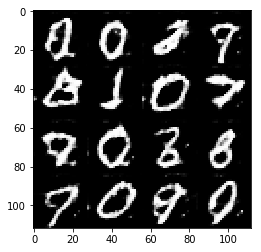

Epoch 1/2... Discriminator Loss: 0.5130... Generator Loss: 1.1933
Epoch 1/2... Discriminator Loss: 0.3612... Generator Loss: 1.4492
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 0.9781


Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 0.8700
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 1.6870
Epoch 2/2... Discriminator Loss: 0.4016... Generator Loss: 1.5641
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 0.8140


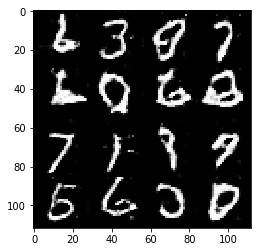

Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 1.4834
Epoch 2/2... Discriminator Loss: 0.4692... Generator Loss: 1.2913


Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.7677
Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 1.6026
Epoch 2/2... Discriminator Loss: 0.2670... Generator Loss: 1.9287


Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 0.3987... Generator Loss: 1.3908


Epoch 2/2... Discriminator Loss: 0.4701... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 1.8021
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 0.2624... Generator Loss: 2.0920


Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 1.3096
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.2679... Generator Loss: 1.9683
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.2027


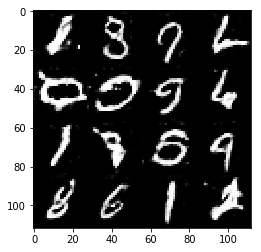

Epoch 2/2... Discriminator Loss: 0.3251... Generator Loss: 1.6158
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 1.2549
Epoch 2/2... Discriminator Loss: 0.2561... Generator Loss: 1.9419
Epoch 2/2... Discriminator Loss: 0.1920... Generator Loss: 3.3871


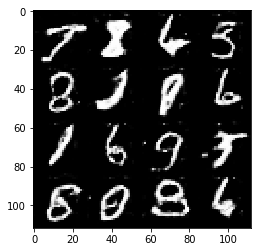

Epoch 2/2... Discriminator Loss: 0.4032... Generator Loss: 1.9822
Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.3662... Generator Loss: 1.5754
Epoch 2/2... Discriminator Loss: 0.2259... Generator Loss: 1.9828


Epoch 2/2... Discriminator Loss: 0.3358... Generator Loss: 1.6349
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 0.2481... Generator Loss: 2.0014
Epoch 2/2... Discriminator Loss: 0.2746... Generator Loss: 1.8769


Epoch 2/2... Discriminator Loss: 0.4885... Generator Loss: 1.4127
Epoch 2/2... Discriminator Loss: 0.2964... Generator Loss: 1.7017
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 0.4156... Generator Loss: 1.5001


Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 0.3655... Generator Loss: 2.1092
Epoch 2/2... Discriminator Loss: 0.2656... Generator Loss: 1.9824
Epoch 2/2... Discriminator Loss: 0.2467... Generator Loss: 1.9029


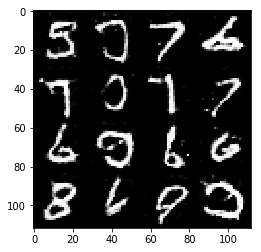

Epoch 2/2... Discriminator Loss: 0.1981... Generator Loss: 2.7351
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 0.3253... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.3342... Generator Loss: 1.6608


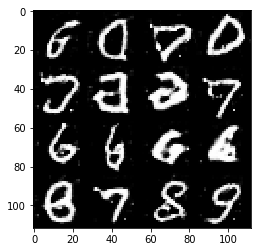

Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 3.4100
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 1.8931
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 1.2997
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.0558


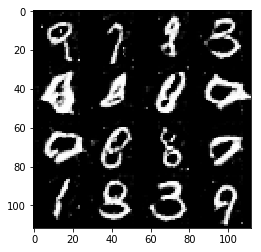

Epoch 2/2... Discriminator Loss: 0.2741... Generator Loss: 1.8431
Epoch 2/2... Discriminator Loss: 0.2591... Generator Loss: 1.8845
Epoch 2/2... Discriminator Loss: 0.2611... Generator Loss: 1.7736
Epoch 2/2... Discriminator Loss: 0.7053... Generator Loss: 1.0686


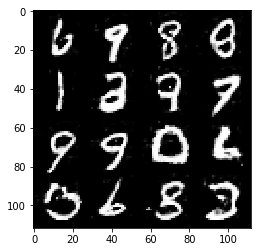

Epoch 2/2... Discriminator Loss: 0.2811... Generator Loss: 1.6498
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 0.3041... Generator Loss: 1.9410
Epoch 2/2... Discriminator Loss: 0.2349... Generator Loss: 1.9669


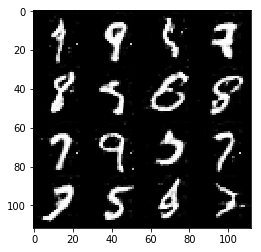

Epoch 2/2... Discriminator Loss: 0.1370... Generator Loss: 2.7489
Epoch 2/2... Discriminator Loss: 0.3698... Generator Loss: 1.6976
Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 1.6049
Epoch 2/2... Discriminator Loss: 0.3384... Generator Loss: 1.6429


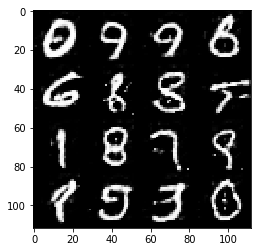

Epoch 2/2... Discriminator Loss: 0.4886... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 0.3332... Generator Loss: 1.5587
Epoch 2/2... Discriminator Loss: 0.4083... Generator Loss: 3.0427


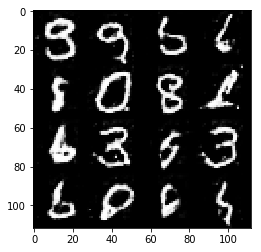

Epoch 2/2... Discriminator Loss: 0.2874... Generator Loss: 1.9881
Epoch 2/2... Discriminator Loss: 0.1817... Generator Loss: 2.1973
Epoch 2/2... Discriminator Loss: 0.4899... Generator Loss: 1.3417
Epoch 2/2... Discriminator Loss: 0.2934... Generator Loss: 1.7627


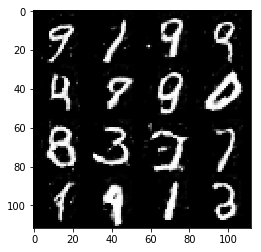

Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 0.2073... Generator Loss: 2.1193


In [73]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 0.9992


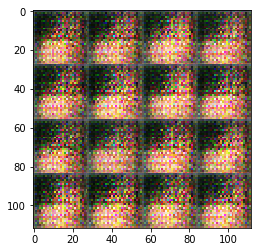

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.8197


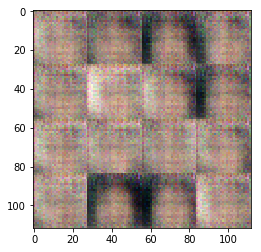

Epoch 1/1... Discriminator Loss: 0.3134... Generator Loss: 2.4147
Epoch 1/1... Discriminator Loss: 0.1661... Generator Loss: 2.3592
Epoch 1/1... Discriminator Loss: 0.2695... Generator Loss: 1.8615
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.4889


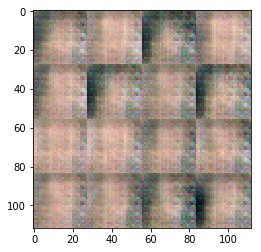

Epoch 1/1... Discriminator Loss: 0.2029... Generator Loss: 3.9609
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 3.4358
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 1.9073


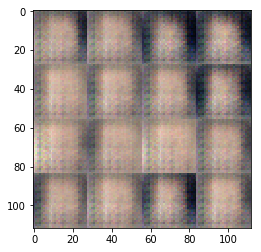

Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 3.6906
Epoch 1/1... Discriminator Loss: 0.0966... Generator Loss: 3.7540
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 4.8823
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 1.7378


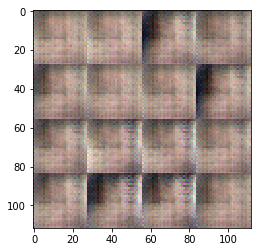

Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 5.3784
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 5.3325
Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 3.6828
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 3.9776


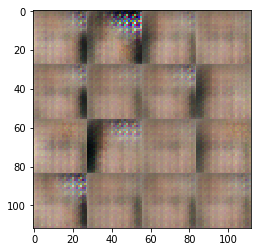

Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 3.9888
Epoch 1/1... Discriminator Loss: 3.4479... Generator Loss: 5.9015
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 0.2292... Generator Loss: 2.1788


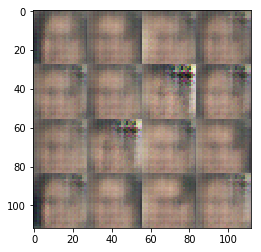

Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 3.9273
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 4.3430
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 5.4636
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 3.0103


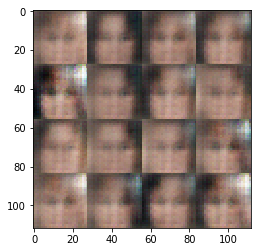

Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 3.7434
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 4.8326
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 5.7869
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 5.9366


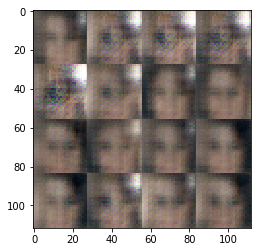

Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 6.2079
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 4.0688
Epoch 1/1... Discriminator Loss: 0.2787... Generator Loss: 1.9132
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 1.7099


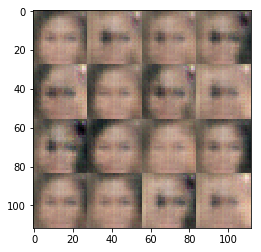

Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 5.6399
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 2.9030
Epoch 1/1... Discriminator Loss: 0.0231... Generator Loss: 4.3581
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 4.6024


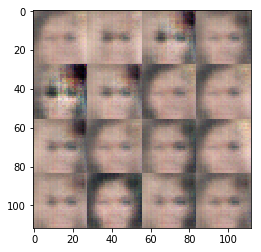

Epoch 1/1... Discriminator Loss: 0.0857... Generator Loss: 3.0964
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 4.5182
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 5.4343
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 5.4114


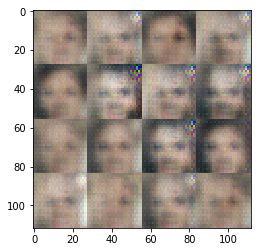

Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 4.4282
Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 6.2285
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 5.7652
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 6.0500


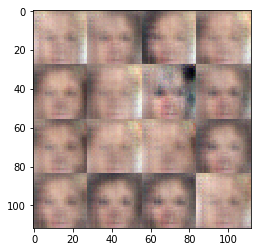

Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 4.4786
Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 3.8386
Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 6.3712


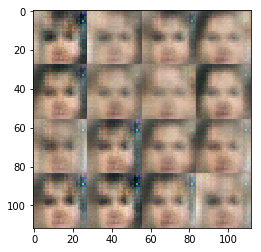

Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 6.6847
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 6.0324
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.4572
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 6.2355


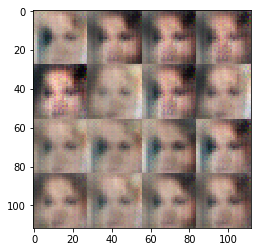

Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 7.5158
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 4.9832
Epoch 1/1... Discriminator Loss: 0.0160... Generator Loss: 4.8317
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 5.5494


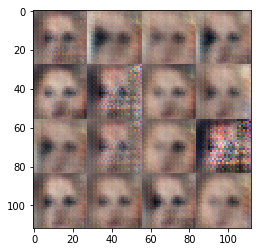

Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 7.8675
Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 5.7306
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 4.8913
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 4.1928


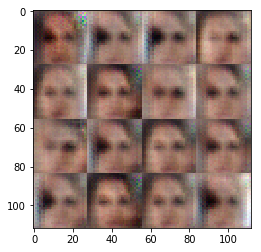

Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 5.3715
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.0937
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 6.0167
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 1.9411


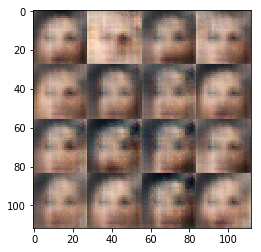

Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 6.1786
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 6.2235
Epoch 1/1... Discriminator Loss: 0.0335... Generator Loss: 6.2782
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 7.0073


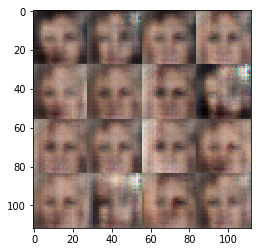

Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 5.1009
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 4.9574
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 4.7047
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 4.7517


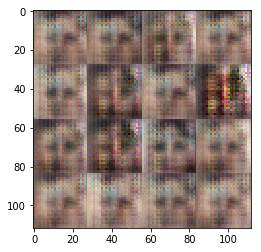

Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 5.1242
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 5.3326
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.5217
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 5.3371


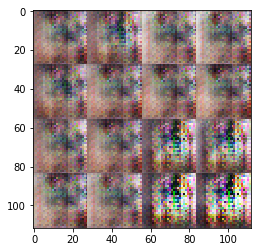

Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 5.1136
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 4.9778
Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 3.0071
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 4.4754


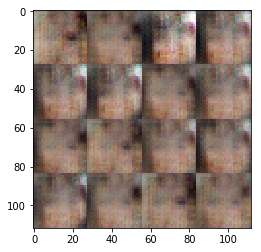

Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 3.1805
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 5.1533
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 5.8763
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 5.6799


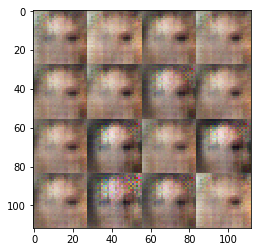

Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 5.1906
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 5.3411
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 5.7172
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 5.6182


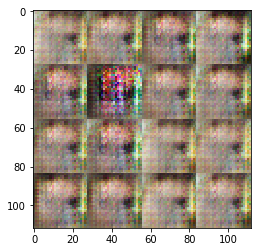

Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 5.6334
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 5.3525
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.8161
Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 9.1102


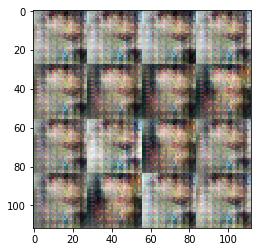

Epoch 1/1... Discriminator Loss: 2.9692... Generator Loss: 3.4443
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 3.8664
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 1.2151


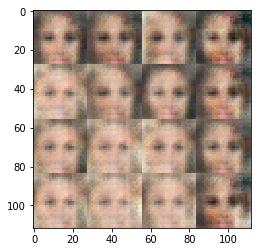

Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 5.3098
Epoch 1/1... Discriminator Loss: 0.0168... Generator Loss: 6.9000
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 7.3080
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 6.9190


Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 5.8854
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 5.3477
Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 6.9533
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 7.7123


Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 5.4274
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 6.6146
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.3910
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 5.8086


Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 5.2482
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 5.0910
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 5.1801
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 5.0078


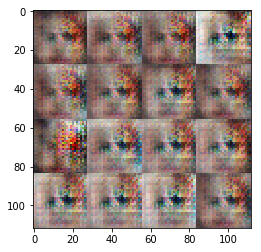

Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 5.8479
Epoch 1/1... Discriminator Loss: 0.1278... Generator Loss: 2.4954
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 7.9692
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 6.5222


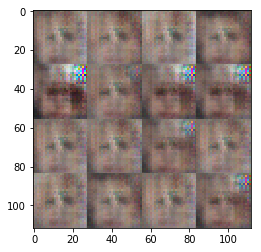

Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 6.2921
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 5.5726
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.3621
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.0021


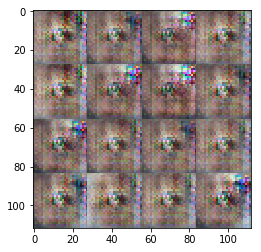

Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.0555
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 5.6534
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 6.0636
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 6.2286


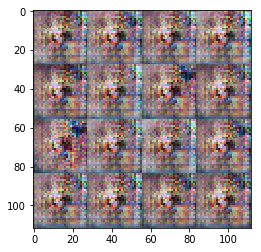

Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 5.7007
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 5.8771
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 7.0764
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 6.9227


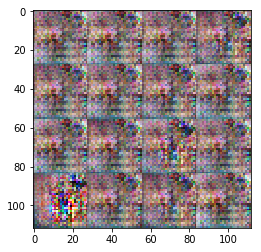

Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 6.0691
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 6.0201
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.3126
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.3605


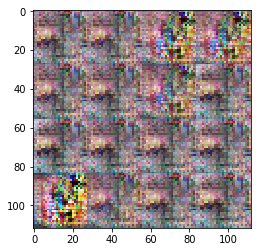

Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.3775
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.5407
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 8.7154
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 9.1867


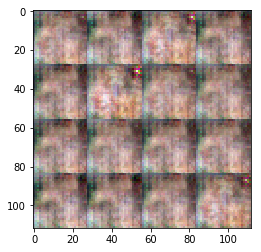

Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 5.1742
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 1.5730
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 2.0760
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 3.9490


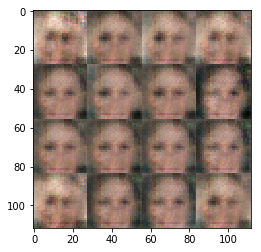

Epoch 1/1... Discriminator Loss: 0.0716... Generator Loss: 4.4346
Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 2.3270
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 4.4342
Epoch 1/1... Discriminator Loss: 0.0573... Generator Loss: 4.1442


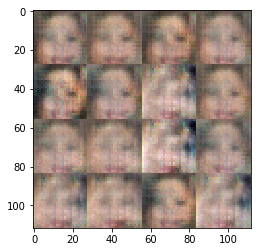

Epoch 1/1... Discriminator Loss: 0.0900... Generator Loss: 2.8262
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 7.4287
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 4.2748


Epoch 1/1... Discriminator Loss: 0.2125... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 4.3573
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 7.7635
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 5.9620


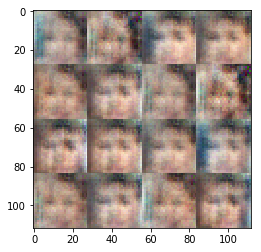

Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 2.3282
Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 7.9842
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 0.2259... Generator Loss: 1.9958


Epoch 1/1... Discriminator Loss: 0.2175... Generator Loss: 5.6438
Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 5.3931
Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 4.9310
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 5.0630


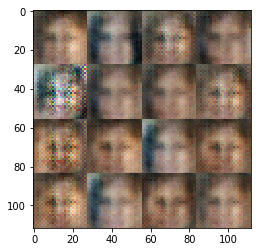

Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 5.8864
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.1774
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 5.6442
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 5.6594


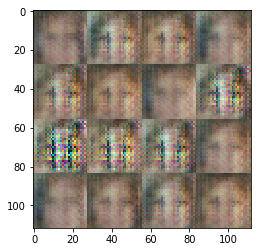

Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 4.7373
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 5.3879
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 5.3625
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 5.2975


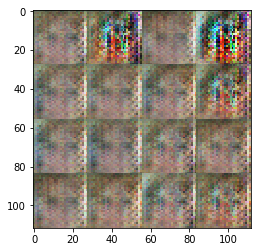

Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.4891
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 5.4320
Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 3.9964
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 3.7224


Epoch 1/1... Discriminator Loss: 0.2554... Generator Loss: 3.7384
Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 3.7128
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 2.3531
Epoch 1/1... Discriminator Loss: 0.1756... Generator Loss: 2.2068


Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 4.9352
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 7.8887
Epoch 1/1... Discriminator Loss: 0.2498... Generator Loss: 4.4194


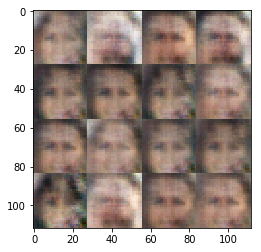

Epoch 1/1... Discriminator Loss: 0.2818... Generator Loss: 2.6633
Epoch 1/1... Discriminator Loss: 0.2282... Generator Loss: 5.4326
Epoch 1/1... Discriminator Loss: 0.2088... Generator Loss: 2.3440
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 4.1592


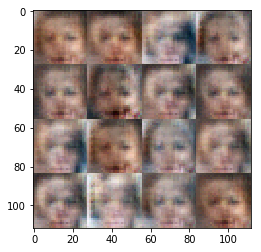

Epoch 1/1... Discriminator Loss: 0.3140... Generator Loss: 4.1738
Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 6.5478
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 1.5597


Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 4.5556
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 3.1721
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 3.8783
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.3825


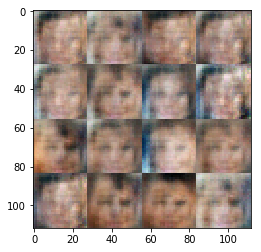

Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 5.0516
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 4.0343
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.5006


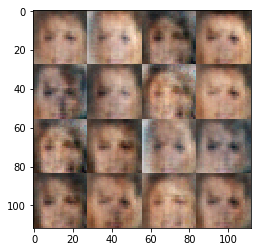

Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 3.4748
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 2.3162
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 1.8746
Epoch 1/1... Discriminator Loss: 0.1193... Generator Loss: 4.9681


Epoch 1/1... Discriminator Loss: 0.2093... Generator Loss: 4.8563
Epoch 1/1... Discriminator Loss: 0.2831... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.2613
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.0215


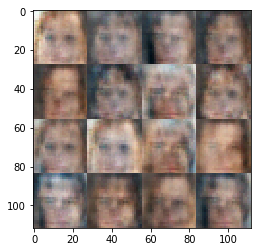

Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 3.7998
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 6.9591
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 5.2909


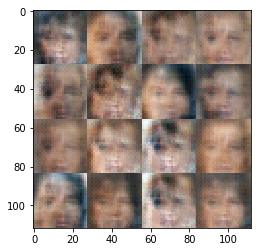

Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 3.4405
Epoch 1/1... Discriminator Loss: 0.2397... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.6360


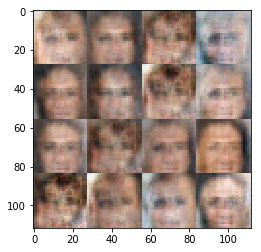

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 0.1223... Generator Loss: 6.5908
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 5.1645
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 3.2189


Epoch 1/1... Discriminator Loss: 0.0817... Generator Loss: 4.2340
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 4.3981
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 1.2016


Epoch 1/1... Discriminator Loss: 0.2282... Generator Loss: 3.2947
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 7.4189
Epoch 1/1... Discriminator Loss: 0.2314... Generator Loss: 4.8985
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 6.6243


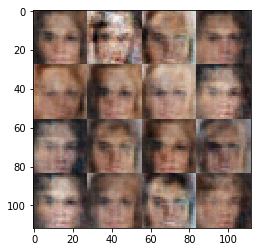

Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 4.9974
Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 3.5219
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 1.7293


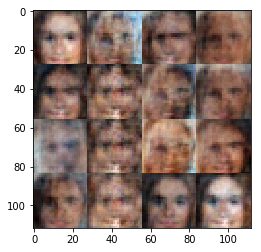

Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 3.8557
Epoch 1/1... Discriminator Loss: 0.0160... Generator Loss: 4.8615
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 5.0284


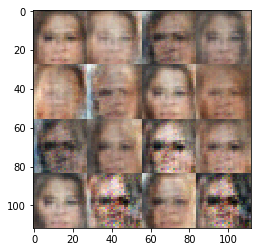

Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 4.6075
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 4.5553
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 4.6589
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 0.7637


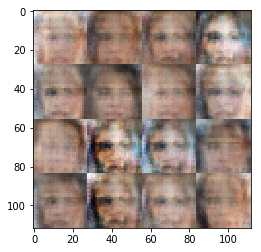

Epoch 1/1... Discriminator Loss: 0.0797... Generator Loss: 3.8132
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 2.5613
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 2.5664
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 7.0679


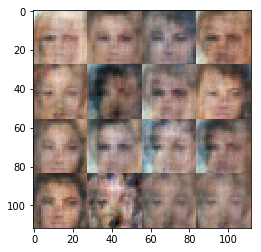

Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 6.6971
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 5.4752
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.1646
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 4.9917


Epoch 1/1... Discriminator Loss: 0.0066... Generator Loss: 5.4617


In [71]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.